### EE 421/521 Image Processing

## Project 5 - Resampling of Images


In this project, you will implement the following:

1. Decimate and interpolate an image
2. Change the sampling rate of an image by a fractional factor

**This project will be graded for both EE 421 (HW4) and EE 521 (HW4) students.**

*Copyright (c) 2020-2022 by Arif Tanju Erdem*

Emirhan Benderli

In [90]:
# import necessary packages

# reading/writing image files
from skimage import io
from skimage import color

# displaying images and plots
import matplotlib.pyplot as plt

# array operations
import numpy as np

# signal processing operations
from scipy import signal
from scipy.linalg import circulant

# mathematical calculations
import math
import cmath

# DFT calculations
from scipy import fftpack as ft

# Mount Google Drive folder to Colab
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [91]:
# my function to round image data to nearest integer, then
# truncate to range [0, 255], and then set data type to uint8

def my_imgTruncate(img):

    img = np.round(img, 0)
    img = np.minimum(img, 255)
    img = np.maximum(img, 0)
    img = img.astype('uint8')

    return img

# end of function

In [92]:
# display an image in original size

def my_display_actual_size(img, str_caption):

    height, width = img.shape

    # determine a figure size big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc.
    margin = 0.05
    dpi = 80
    figsize = (1.0+margin)*height/dpi, (1.0+margin)*width/dpi

    # define the figure
    fig = plt.figure(figsize=figsize, dpi=dpi)

    # make the axis the right size
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    # display the image
    ax.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
    plt.title(str_caption)
    plt.show()

    return

# end of function

Image width is 256 and image height is 256.


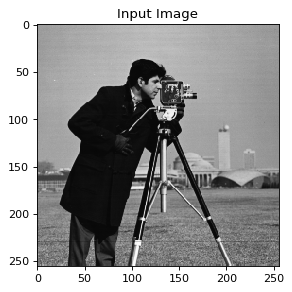

In [93]:
# STEP 1 Pick an image

# set image folder
image_folder = r'/content/drive/MyDrive/Colab Notebooks/EE421/images'

# read input image
image_file = r'/cameraman.tiff'
image_path = image_folder + image_file
imgRGB = io.imread(image_path)

if imgRGB.ndim == 3:
    # calculate the luminance image
    img = imgLuminance(imgRGB)
else:
    img = imgRGB

height, width = img.shape
print("Image width is {} and image height is {}.".format(width, height))

# display image in actual size
my_display_actual_size(img,'Input Image')

In [94]:
# calculate the RMSE between two images

def RMSE(img1, img2):

    assert img1.ndim == img2.ndim
    assert img1.size == img2.size

    return math.sqrt(((img1 - img2) ** 2).sum() / img1.size)

# end of function

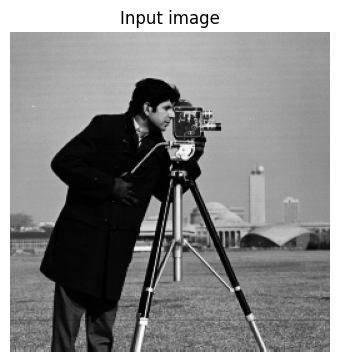

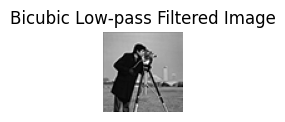

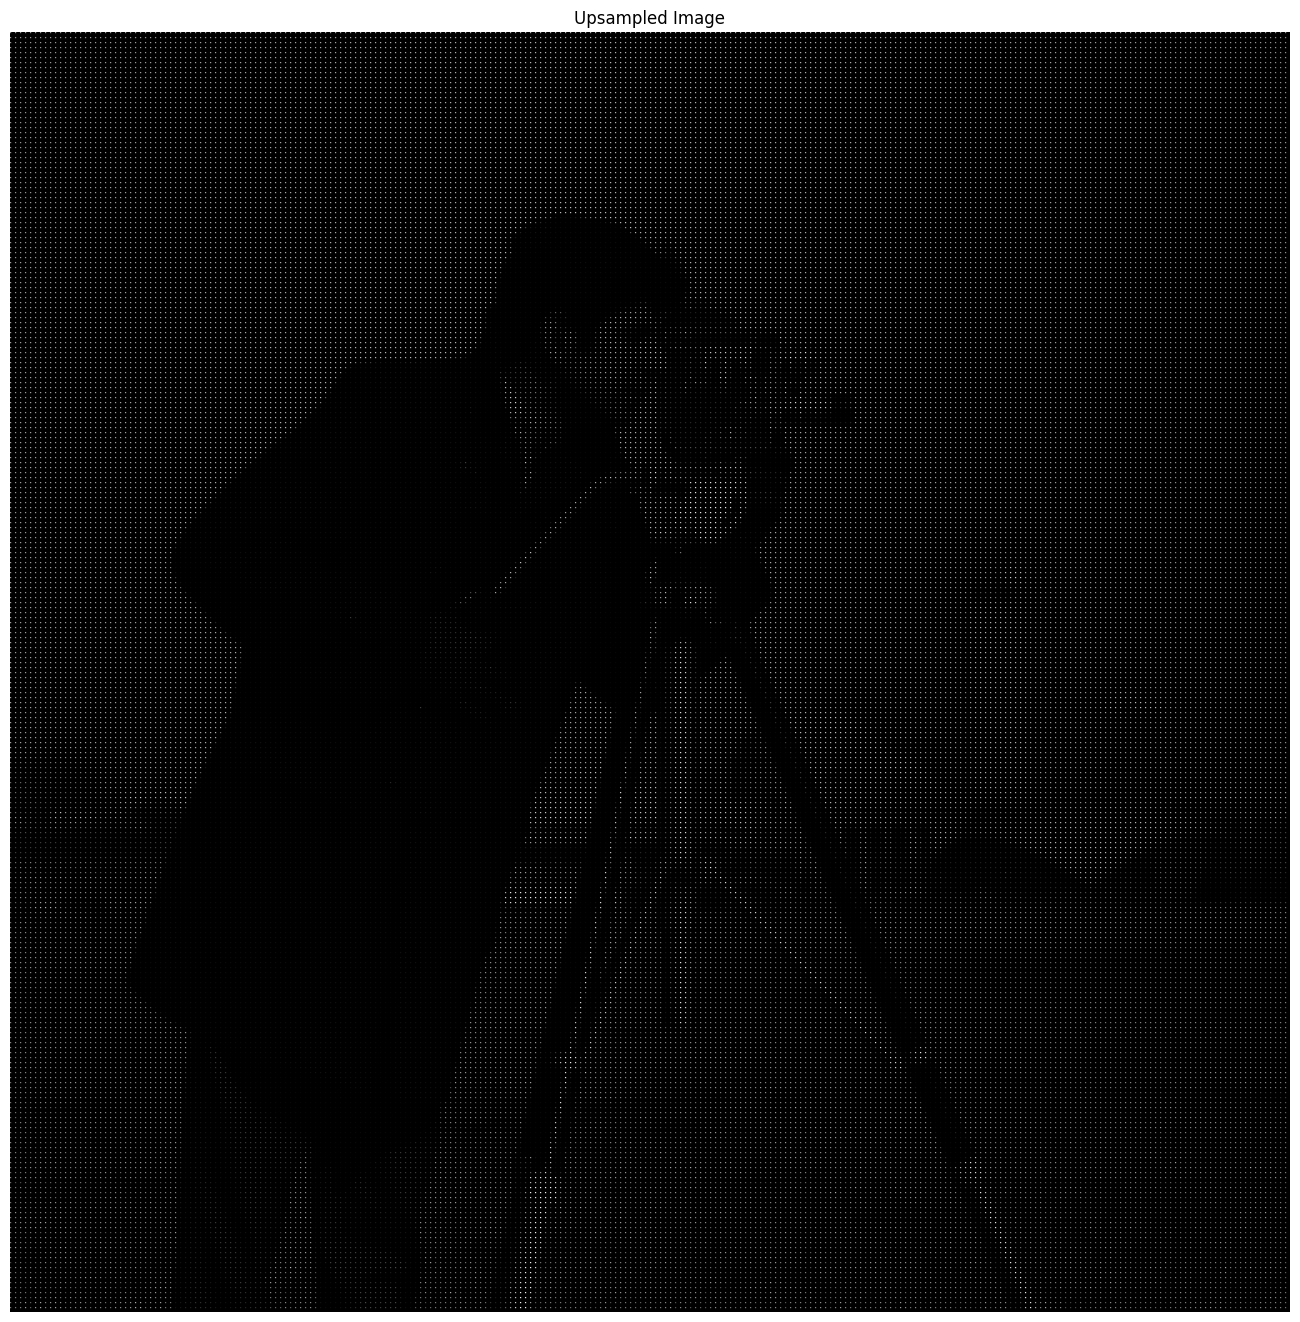

In [ ]:
# STEP 2 First decimate and then interpolate an image

#---------------------------------------------------------------
# Low-pass filter the image by a factor of 4 in both directions
# using the cubic spline filter
#---------------------------------------------------------------

def cubic_filter(filter1):

    assert filter1 >= 1

    size_filter = filter1 * 4 - 1

    filter_cubic= np.zeros((size_filter,))

    filter_cubic[size_filter // 2] = 1.0

    for i in range(1,filter1):
        x = i/filter1
        filter_cubic[size_filter // 2 + i] = 1.0 - x**2

    for i in range(filter1 + 1, filter1 * 2):
        x = i/filter1
        filter_cubic[size_filter // 2 + i] = -2 * (x - 1) * (x - 2) ** 2

    filter_cubic[:size_filter // 2] = filter_cubic[-1:size_filter // 2:-1]

    return filter_cubic
def display_image(image_data, str_caption, dpi = 80):


  # Get image height, width, and channel depth
  height, width = image_data.shape

  # Calculate figure size based on image dimensions and desired dpi
  figsize = width / float(dpi) , height / float(dpi)

  # Create a figure with one axes taking up the full area
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])

  # Hide axes and ticks for a cleaner presentation (optional)
  ax.axis("off")

  # Display the image
  ax.imshow(image_data, cmap= "gray")  # Adjust cmap for color/grayscale images
  plt.title(str_caption)
  plt.show()

# setting coefficients
down_factor = 4
my_filter = cubic_filter(down_factor)
filter2D = np.outer(my_filter, my_filter)
filter2D =  filter2D / filter2D.sum()

# low-pass filtered image
img_dec = signal.convolve2d(img, filter2D, mode= "same", boundary= "fill", fillvalue= 128)
img_dec = my_imgTruncate(img_dec)

# downsample image
img_dec = img_dec[::down_factor,::down_factor]

# display image in actual size
display_image(img, "Input image")

# display image
display_image(img_dec, "Bicubic Low-pass Filtered Image")
image_path = image_folder + image_file
imgRGB = io.imread(image_path)

if imgRGB.ndim == 3:
    img = imgLuminance(imgRGB)
else:
    img = imgRGB


#Upsampling the image: Insert zero-valued pixels
up_factor = 4
img_up = np.zeros((height * up_factor,width * up_factor))

# upsample image
img_up[::up_factor,::up_factor] = img

# display image
display_image(img_up, "Upsampled Image")

# setting coefficients
up_factor = 4
my_filter = cubic_filter(up_factor)
filter2D = np.outer(my_filter,my_filter)
# (note: there is no normalization of filter coefficients in the case of interpolation)

# 2D convolution
img_interp = signal.convolve2d(img_up, filter2D, mode= "same", boundary= "fill", fillvalue=128)
img_interp = my_imgTruncate(img_interp)

# display image
display_image(img_interp, "Interpolated Image with Bicubic Low-pass Filter")




In [ ]:
# STEP 3 Demonstrate the importance of the order of interpolation and decimation

#---------------------------------------------------------------
# Calculate and print the RMSE between the original image and the image obtained in Step 2 above
#---------------------------------------------------------------

# Resampling decimated image into its original size by interpolation
img_interpolated = signal.resample(img_dec, img.shape[0], axis=0)
img_interpolated = signal.resample(img_interpolated, img.shape[1], axis=1)

# Calculating RMSE
rmse = RMSE(img, img_interpolated)
print("RMSE between original and decimated interpolated image is:", rmse)



In [ ]:
# STEP 4 Decrease the size of the image by 33.33% horizontally
# while increasing its size by 50% vertically

#---------------------------------------------------------------
# Decrease the size of the image horizontally by 33.33%
#---------------------------------------------------------------

horizontal_scale = 0.6667  # 33.33% decrease
img_horizontal_resized = signal.resample(img, int(width * horizontal_scale), axis=1)

#---------------------------------------------------------------
# Increaset the size of the resulting image vertically by 50%
#---------------------------------------------------------------

vertical_scale = 1.5  # 50% increase
img_resize = signal.resample(img_horizontal_resized, int(height * vertical_scale), axis=0)

#---------------------------------------------------------------
# Display the final image
#---------------------------------------------------------------
display_image(img_resize, "Resized Image")



*STEP 5 Comments on the results*

*ADD YOUR COMMENTS HERE*

Explain why in Step 2 above the decimated and then interpolated image is not the same as the original image.

When we are downsizing the image we are deleting some of the details and when we try to bring it back we are guessing what those details might be. So it's not equal to an undo, we can't fully recover the original image.
